In [1]:
%matplotlib
import torch
import torch.nn.functional as F

import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj, add_self_loops
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os
os.chdir("../")

import sys
sys.path.append('../scripts')

# loading scripts from here
from eval_link_prediction import accuracy, precision, recall
from link_prediction import negative_sampling, balanced_samples

"""
This is an implementation from:
https://github.com/tkipf/pygcn/blob/master/pygcn/layers.py

Author: Thomas kipf
Paper: 
Semi-Supervised Classification with Graph Convolutional Networks
https://arxiv.org/abs/1609.02907
"""

from GCNConv import GraphConvolution

Using matplotlib backend: agg


# GraphConv

In [2]:
"""
This is an implementation from:
https://github.com/tkipf/pygcn/blob/master/pygcn/models.py

Model and training settings are from:
https://github.com/tkipf/pygcn/blob/master/pygcn/train.py
which is the same as reported from the paper.

Author: Thomas kipf
"""
class Net(torch.nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Net, self).__init__()

        self.gc1 = GraphConvolution(in_channel, 16)
        self.gc2 = GraphConvolution(16, out_channel)
        
        # predict exists or not
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2 * out_channel, 50),
            torch.nn.ELU(),
            torch.nn.Linear(50, 1),
            torch.nn.Sigmoid()
        )
        
    def forward(self, data, query_index):
        x, adj = data.x, data.adj
        
        # generate node embeddings 
        emb = F.relu(self.gc1(x, adj))
        emb = F.dropout(emb, p=0.5, training=self.training)
        emb = self.gc2(emb, adj)
        
        # get queried embeddings
        emb_query = torch.cat((emb[query_index[0]], emb[query_index[1]]), dim=1)
        
        # using embeddings to get score out
        score = self.layers(emb_query)
        return score

# Compile Model

In [3]:
from tqdm import tqdm

NUMEPOCHS = 10000
early_stop_win_size = 100
tolerance = 1.00

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# load data
name = 'Cora'
dataset = Planetoid('../datasets/'+ name, name=name)
data = dataset.data

# compile model
in_dim = dataset.num_node_features

model = Net(
    in_dim,
    50
).to(device)

# optimizer
optimizer = torch.optim.Adamax(model.parameters(), weight_decay=1e-4)

# loss function
criterion = torch.nn.modules.loss.BCELoss()

# Split the Dataset

In [4]:
# random sampling edges
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

# split edges
edges = data.edge_index.detach().cpu().numpy().T
edge_train, edge_test = train_test_split(edges, train_size=train_frac, random_state=42)
edge_val, edge_test = train_test_split(
    edge_test, 
    train_size=val_frac/(test_frac + val_frac), 
    random_state=42
)

# create train, validation, test positive edges
data.edge_train = torch.Tensor(edge_train).long().t()
data.edge_val = torch.Tensor(edge_val).long().t()
data.edge_test = torch.Tensor(edge_test).long().t()
data.y_train = torch.ones(len(edge_train), 1).long().t()
data.y_val = torch.ones(len(edge_val), 1).long().t()
data.y_test = torch.ones(len(edge_test), 1).long().t()

# create adjacency matrix
data.adj = to_dense_adj(add_self_loops(data.edge_train)[0])[0]

# to device (GPU default)
data = dataset.data.to(device)

# record the 
num_nodes = data.x.shape[0]
num_edges = data.edge_index.shape[1]
num_train = len(data.edge_train.t())
num_val = len(data.edge_val.t())
num_test = len(data.edge_test.t())

print('Number of nodes =', num_nodes)
print('Number of edges =', num_edges)
print('Training edges =', num_train)
print('Validation edges =', num_val)
print('Test edges =', num_test)

Number of nodes = 2708
Number of edges = 10556
Training edges = 8444
Validation edges = 1056
Test edges = 1056


# Training

In [5]:
# record accuracy
train_loss = np.zeros(NUMEPOCHS)
val_loss = np.zeros(NUMEPOCHS)
test_loss = np.zeros(NUMEPOCHS)

# negative sampling
edge_test, y_test = balanced_samples(data.edge_test, num_nodes)

# training start
for epoch in range(NUMEPOCHS):
    # negative sampling
    edge_train, y_train = balanced_samples(data.edge_train, num_nodes)
    edge_val, y_val = balanced_samples(data.edge_val, num_nodes)
    
    model.train()
    optimizer.zero_grad()
    out = model(data, edge_train)
    loss = criterion(out, y_train.float())
    loss.backward()
    optimizer.step()
    
    # record the accuracy
    train_loss[epoch] = loss.item()
    model.eval()
    val_loss[epoch] = criterion(model(data, edge_val), y_val.float()).item()
    test_loss[epoch] = criterion(model(data, edge_test), y_test.float()).item()

    if epoch % 500 == 0:
        print(
            epoch, 
            ', train loss =', loss.item(),
            ', val loss =', val_loss[epoch], 
        )

0 , train loss = 0.8196955919265747 , val loss = 0.738463282585144
500 , train loss = 0.2962469458580017 , val loss = 0.41930893063545227
1000 , train loss = 0.2217046022415161 , val loss = 0.3129737079143524
1500 , train loss = 0.1830608993768692 , val loss = 0.2916935384273529
2000 , train loss = 0.16339382529258728 , val loss = 0.23181234300136566
2500 , train loss = 0.14674465358257294 , val loss = 0.22474724054336548
3000 , train loss = 0.14035025238990784 , val loss = 0.21826870739459991
3500 , train loss = 0.13296939432621002 , val loss = 0.22679361701011658
4000 , train loss = 0.13230177760124207 , val loss = 0.20135630667209625
4500 , train loss = 0.12862561643123627 , val loss = 0.21530136466026306
5000 , train loss = 0.11856380105018616 , val loss = 0.22373183071613312
5500 , train loss = 0.11359941214323044 , val loss = 0.21055485308170319
6000 , train loss = 0.11060881614685059 , val loss = 0.2199171632528305
6500 , train loss = 0.1109602153301239 , val loss = 0.2239959239

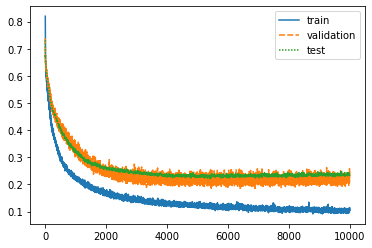

In [6]:
df_acc = pd.DataFrame({
    'train': train_loss,
    'validation': val_loss,
    'test': test_loss
})

sns.lineplot(data=df_acc)
plt.show()

In [7]:
edge_train, y_train = balanced_samples(data.edge_train, num_nodes)
edge_val, y_val = balanced_samples(data.edge_val, num_nodes)
edge_test, y_test = balanced_samples(data.edge_test, num_nodes)

train_score = model(data, edge_train).detach().cpu().numpy().ravel()
val_score = model(data, edge_val).detach().cpu().numpy().ravel()
test_score = model(data, edge_test).detach().cpu().numpy().ravel()

train_pred = (train_score > 0.5).astype(np.int8)
val_pred = (val_score > 0.5).astype(np.int8)
test_pred = (test_score > 0.5).astype(np.int8)

print('Train Accuracy: {:.4f}'.format(accuracy(train_pred, y_train)))
print('Validation Accuracy: {:.4f}'.format(accuracy(val_pred, y_val)))
print('Test Accuracy: {:.4f}'.format(accuracy(test_pred, y_test)))

print('Train Precision: {:.4f}'.format(precision(train_pred, y_train)))
print('Validation Precision: {:.4f}'.format(precision(val_pred, y_val)))
print('Test Precision: {:.4f}'.format(precision(test_pred, y_test)))

print('Train Recall: {:.4f}'.format(recall(train_pred, y_train)))
print('Validation Recall: {:.4f}'.format(recall(val_pred, y_val)))
print('Test Recall: {:.4f}'.format(recall(test_pred, y_test)))

Train Accuracy: 0.9806
Validation Accuracy: 0.9351
Test Accuracy: 0.9299
Train Precision: 0.9627
Validation Precision: 0.9554
Test Precision: 0.9549
Train Recall: 0.9999
Validation Recall: 0.9129
Test Recall: 0.9025


In [2]:
test_acc_all = np.array([0.9380, 0.9370, 0.9356, 0.9337, 0.9299])
test_precision_all = np.array([0.9630, 0.9556, 0.9466, 0.9562, 0.9549])
test_recall_all = np.array([0.9110, 0.9167, 0.9233, 0.9091, 0.9025])

print(np.mean(test_acc_all))
print(np.mean(test_precision_all))
print(np.mean(test_recall_all))

print(np.std(test_acc_all))
print(np.std(test_precision_all))
print(np.mean(test_recall_all))

0.93484
0.95526
0.9125200000000001
0.0028611885642159424
0.005215975460064966
0.9125200000000001


In [4]:
print('$%.2f\pm%.2f$' % (np.mean(test_acc_all) * 100, np.std(test_acc_all) * 100), end=' ')
print('$%.2f\pm%.2f$' % (np.mean(test_precision_all) * 100, np.std(test_precision_all) * 100), end=' ')
print('$%.2f\pm%.2f$' % (np.mean(test_recall_all) * 100, np.std(test_recall_all) * 100), end=' ')

$93.48\pm0.29$ $95.53\pm0.52$ $91.25\pm0.70$ 